In [18]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from datasets.mnist import MNISTDataset
from mixer.mixer import SetMixer

from itertools import product
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [43]:
def multinomial_fr(probs):
    return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))

In [44]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

points_per_dim = 12
k = 3
set_size = 10**4

mix_probs = simplex_grid(k, points_per_dim)

fr_dist = multinomial_fr(mix_probs)

n_sets = len(mix_probs)

mix_probs = torch.tensor(np.repeat(mix_probs, n_sets//k, axis=1))

mix_probs.shape

torch.Size([78, 78])

In [49]:
dataset = MNISTDataset(n_classes=k, n_sets=n_sets, set_size=5000)
mixer = SetMixer(k=k, mixed_set_size=set_size, n_mixed_sets=n_sets)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    collate_fn=mixer.collate_fn,
)

In [ ]:
# flatten the dataset
flat_data = dataset.data.flatten(start_dim=2)
setless_data = flat_data.flatten(end_dim=1)

# normalize! 
scaler = StandardScaler()
norm_data = scaler.fit_transform(setless_data)

n_components = 20
pca = PCA(n_components=n_components)
pcs = pca.fit(norm_data)

In [51]:
mixed_sets = mixer.prescribed_mixing(flat_data, mix_probs)

In [58]:
embs = []

for s in mixed_sets:
    scaler.transform(s)
    embs.append(pcs.transform(s).mean(axis=0))

embs = torch.tensor(embs)

l2_dist = torch.cdist(embs, embs, p=2)

Text(0, 0.5, 'Fisher-Rao')

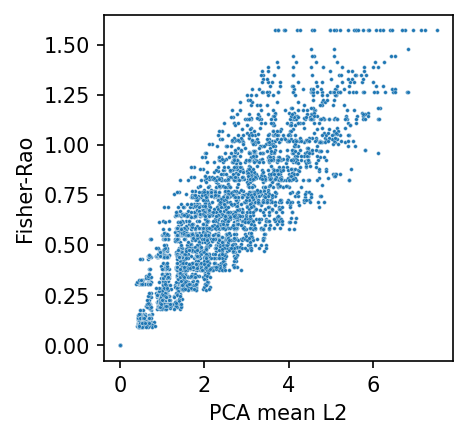

In [59]:
fig = plt.figure(figsize=(3,3), dpi=150)
sns.scatterplot(x=l2_dist.flatten(),
                y=fr_dist.flatten(), s=3)
plt.xlabel("PCA mean L2")
plt.ylabel('Fisher-Rao')

In [63]:
torch.abs(torch.tensor(fr_dist/fr_dist.max()) - l2_dist/l2_dist.max()).mean()

tensor(0.1017, dtype=torch.float64)